In [217]:
# imports
%matplotlib notebook
import matplotlib.pyplot as plt
from camera import take_picture
import numpy as np

In [218]:
# download dlib models
from dlib_models import download_model, download_predictor, load_dlib_models
download_model()
download_predictor()
from dlib_models import models

File already exists:
	/Users/christinaxiao/Christina/COLLEGE/Camps/MIT BWSI/Class/Week 2 - Visual/DlibModels/dlib_models/dlib_face_recognition_resnet_model_v1.dat
File already exists:
	/Users/christinaxiao/Christina/COLLEGE/Camps/MIT BWSI/Class/Week 2 - Visual/DlibModels/dlib_models/shape_predictor_68_face_landmarks.dat


In [219]:
load_dlib_models()
face_detect = models["face detect"]
shape_predictor = models["shape predict"]

In [220]:
def readfile_emotion(filename):
    with open(filename, mode='r') as file:
        return int(float(file.read().split()[0]))

def readfile_landmarks(filename):
    with open(filename, mode='r') as file:
        return np.array([float(x) for x in file.read().split()])

In [231]:
import os
import random

def import_cohn_kanade(dataset="database/Cohn-Kanade", extension=".txt", cutoff=0.25):
    landmarks = []
    emotions = []
    path_landmarks = os.path.join(dataset, "Landmarks")
    path_emotions = os.path.join(dataset, "Emotion")
    # for every subject
    subjects = os.listdir(path_landmarks)
    random.shuffle(subjects)
    for di in subjects:
        dire_landmarks = os.path.join(path_landmarks, di)
        dire_emotions = os.path.join(path_emotions, di)
        if os.path.isdir(dire_landmarks) and os.path.isdir(dire_emotions):
            # for every sequence
            for subdi in os.listdir(dire_landmarks):
                subdire_landmarks = os.path.join(dire_landmarks, subdi)
                subdire_emotions = os.path.join(dire_emotions, subdi)
                if os.path.isdir(subdire_landmarks) and os.path.isdir(subdire_emotions):
                    # find the first and only emotion file
                    emotion = None
                    for fi in os.listdir(subdire_emotions):
                        if fi.endswith(extension) and not fi.startswith("._"):
                            path = os.path.join(subdire_emotions, fi)
                            emotion = readfile_emotion(path)
                            break
                    # for every neutral landmark
                    valid = [fi for fi in os.listdir(subdire_landmarks) if fi.endswith(extension) and not fi.startswith("._")]
                    split = int(len(valid)*cutoff)
                    for fi in valid[:split]:
                        path = os.path.join(subdire_landmarks, fi)
                        landmark = readfile_landmarks(path)
                        # add to return array
                        emotions.append(0)
                        landmarks.append(landmark)
                    if emotion is None:
                        continue
                    # for every emotional landmark
                    for fi in valid[split:]:
                        path = os.path.join(subdire_landmarks, fi)
                        landmark = readfile_landmarks(path)
                        # add to return array
                        emotions.append(emotion)
                        landmarks.append(landmark)
    return np.array(landmarks), np.array(emotions)

In [247]:
x, y = import_cohn_kanade()

In [248]:
labels = ["neutral", "angry", "contempt", "disgusted", "afraid", "happy", "sad", "surprised"]
new_labels = ["sad", "neutral", "happy"]
transform = [1, 0, 1, 0, 0, 2, 0, 2]

y = np.array([transform[i] for i in y])

In [249]:
# normalize
x = x.reshape((-1, 68, 2))

mean = np.mean(x, axis=1, keepdims=True)
std = np.std(x, axis=1, keepdims=True)

x = ((x - mean) / std).reshape(-1, 68*2)

In [250]:
import sklearn

N = x.shape[0]
split = round(N*0.9)

xtrain = x[:split]
ytrain = y[:split]
xtest = x[split:]
ytest = y[split:]

# shuffle after to get new people in test
xtrain, ytrain = sklearn.utils.shuffle(xtrain, ytrain)
xtest, ytest = sklearn.utils.shuffle(xtest, ytest)

<IPython.core.display.Javascript object>


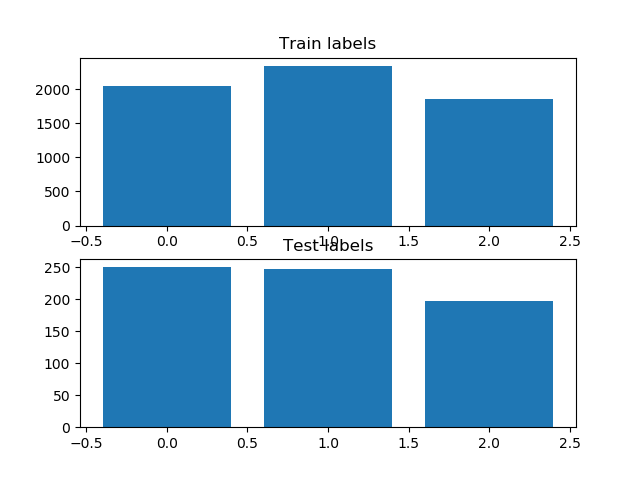

In [251]:
from collections import Counter

fig, ax = plt.subplots(2)

hist_train = [0]*3
hist_test = [0]*3
for i, c in Counter(ytrain).items():
    hist_train[i] = c
for i, c in Counter(ytest).items():
    hist_test[i] = c
ax[0].bar(range(3), hist_train)
ax[1].bar(range(3), hist_test)
ax[0].set_title("Train labels");
ax[1].set_title("Test labels");

<IPython.core.display.Javascript object>


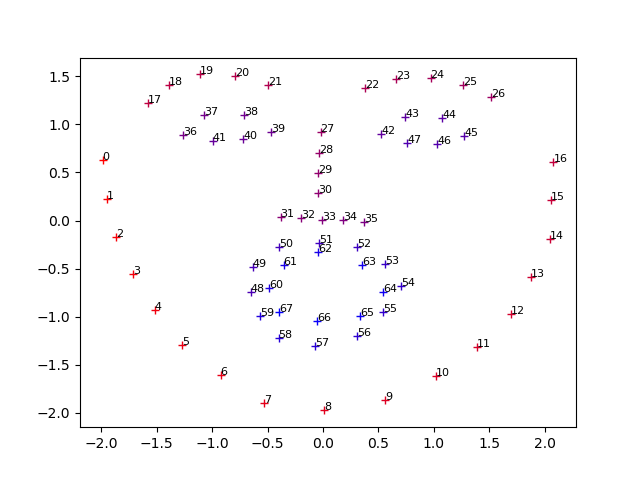

In [252]:
fig, ax = plt.subplots()

# you can disable sklearn shuffling to see animations
for index in range(xtrain.shape[0]//100):
    ax.clear()
    for i in range(68):
        ax.plot(xtrain[index][2*i],-xtrain[index][2*i+1],'+',color=(1-i/68, 0, i/68))
        ax.text(xtrain[index][2*i],-xtrain[index][2*i+1],str(i),color="black",fontsize=8)
    fig.canvas.draw()

In [268]:
from mynn.layers.dense import dense
from mynn.initializers.glorot_normal import glorot_normal
from mynn.activations.relu import relu

class Model:
    def __init__(self):
        self.dense1 = dense(2*68, 100, weight_initializer=glorot_normal)
        self.dense2 = dense(100, 10, weight_initializer=glorot_normal)
        self.dense3 = dense(10, 3, weight_initializer=glorot_normal)
    
    def __call__(self, x):
        return self.dense3(relu(self.dense2(relu(self.dense1(x)))))
    
    @property
    def parameters(self):
        return self.dense1.parameters + self.dense2.parameters + self.dense3.parameters

In [269]:
import mygrad as mg

def accuracy(predictions, truth):
    if isinstance(predictions, mg.Tensor):
        predictions = predictions.data
    return np.mean(np.argmax(predictions, axis=1) == truth)

In [270]:
from mynn.optimizers.adam import Adam
import liveplot

model = Model()
optim = Adam(model.parameters)

<IPython.core.display.Javascript object>


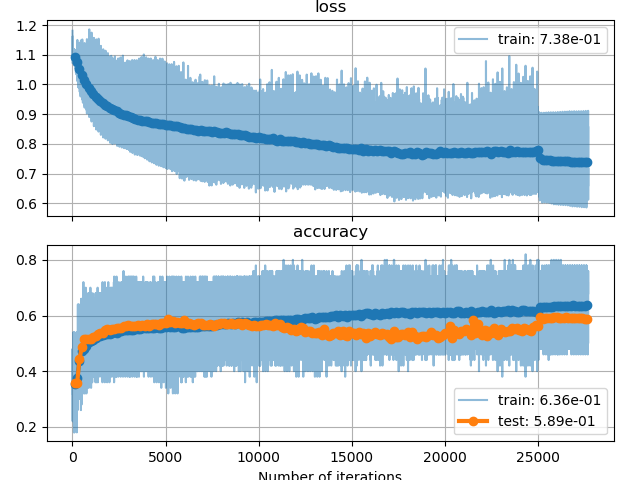

In [271]:
import liveplot
plotter, fig, ax = liveplot.create_plot(metrics=["loss", "accuracy"], refresh=2.5)

In [277]:
from mynn.losses.cross_entropy import softmax_cross_entropy
from math import ceil

optim.learning_rate = 1e-4
optim.weight_decay = 1e-6

batch_size = 50
epochs = 25

Ntrain = ceil(xtrain.shape[0] / batch_size)
Ntest = ceil(xtest.shape[0] / batch_size)
for epoch in range(epochs):
    # train
    for x_batch, y_batch in zip(np.array_split(xtrain, Ntrain), np.array_split(ytrain, Ntrain)):
        y_pred = model(x_batch)

        loss = softmax_cross_entropy(y_pred, y_batch)
        acc = accuracy(y_pred, y_batch)

        loss.backward()
        optim.step()
        loss.null_gradients()

        plotter.set_train_batch({"loss":loss.item(),
                                 "accuracy":acc},
                                 batch_size=batch_size)
    # test
    for x_batch, y_batch in zip(np.array_split(xtest, Ntest), np.array_split(ytest, Ntest)):
        y_pred = model(x_batch)
        
        acc = accuracy(y_pred, y_batch)

        y_pred.null_gradients()

        plotter.set_test_batch({"accuracy":acc}, 
                                 batch_size=batch_size)
    plotter.plot_train_epoch()
    plotter.plot_test_epoch()

In [306]:
import pickle

# pickling parameters
with open("emotion_net_parameters.dat", mode="wb") as f:
    pickle.dump(model.parameters, f)

In [279]:
# loading parameters
with open("emotion_net_parameters.dat", mode="rb") as f:
    new_parameters = pickle.load(f)

# new model
class NewModel:
    def __init__(self):
        self.dense1 = dense(2*68, 100, weight_initializer=glorot_normal)
        self.dense1.weight = new_parameters[0]
        self.dense1.bias = new_parameters[1]
        self.dense2 = dense(100, 10, weight_initializer=glorot_normal)
        self.dense2.weight = new_parameters[2]
        self.dense2.bias = new_parameters[3]
        self.dense3 = dense(10, 3, weight_initializer=glorot_normal)
        self.dense3.weight = new_parameters[4]
        self.dense3.bias = new_parameters[5]
    
    def __call__(self, x):
        return self.dense3(relu(self.dense2(relu(self.dense1(x)))))
    
    @property
    def parameters(self):
        return self.dense1.parameters + self.dense2.parameters + self.dense3.parameters

---------------------------------------------
Now, try with a real picture!

<IPython.core.display.Javascript object>


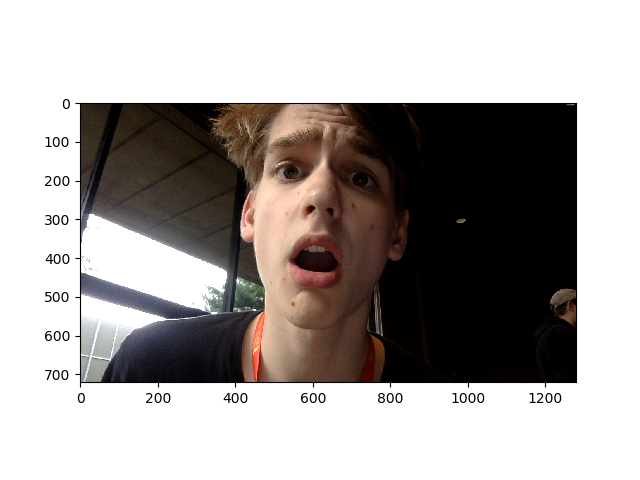

In [295]:
# take picture!
fig,ax = plt.subplots()
pic = take_picture()
ax.imshow(pic)

In [296]:
detections = list(face_detect(pic))
print(detections)

[rectangle(445,115,816,486)]


<IPython.core.display.Javascript object>


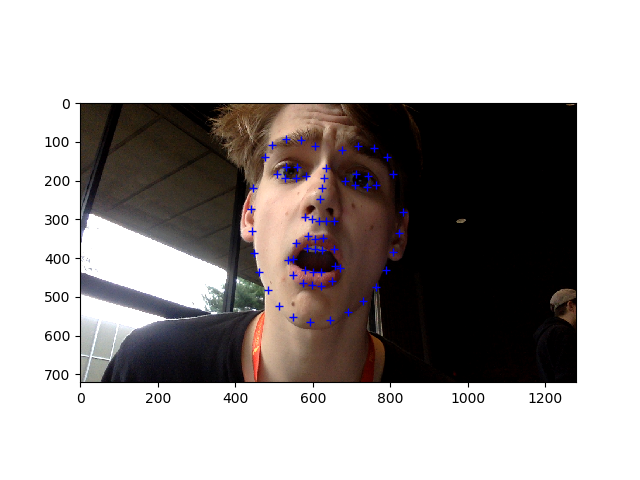

Number of faces detected: 1


In [297]:
from matplotlib.patches import Rectangle
fig,ax = plt.subplots()
ax.imshow(pic)


print("Number of faces detected: {}".format(len(detections)))
for k, d in enumerate(detections):
    # Get the landmarks/parts for the face in box d.
    landmarks = shape_predictor(pic, d)
    # Draw the face landmarks on the screen.
    for i in range(68):
        ax.plot(landmarks.part(i).x,landmarks.part(i).y,'+',color="blue")

In [298]:
landmarks = shape_predictor(pic, detections[0])
landmarks_arr = np.empty((68, 2))
for i in range(68):
    landmarks_arr[i, 0] = landmarks.part(i).x
    landmarks_arr[i, 1] = landmarks.part(i).y

mean = np.mean(landmarks_arr, axis=0)
std = np.std(landmarks_arr, axis=0)
landmarks_norm = (landmarks_arr - mean) / std

<IPython.core.display.Javascript object>


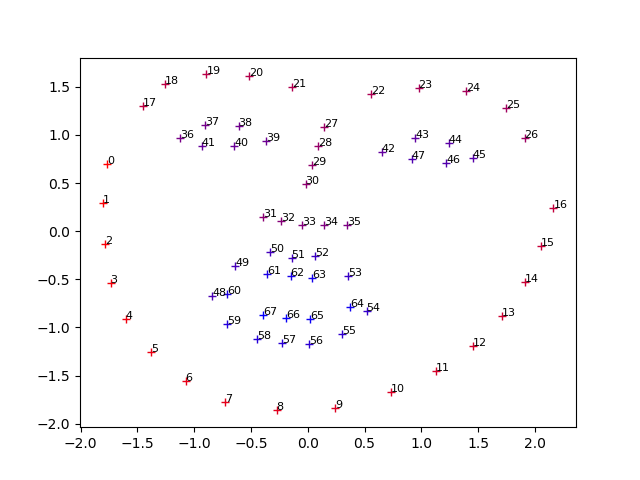

In [299]:
fig,ax = plt.subplots()

for i in range(68):
    ax.plot(landmarks_norm[i][0],-landmarks_norm[i][1],'+',color=(1-i/68, 0, i/68))
    ax.text(landmarks_norm[i][0],-landmarks_norm[i][1],str(i),color="black",fontsize=8)

In [300]:
from mynn.activations.softmax import softmax

# try to detect the emotion
landmarks_final = landmarks_norm.reshape(68*2)

probs = model(landmarks_final)
probs_soft = softmax(probs)
result = {emotion:probs_soft.data[0][i] for i, emotion in enumerate(new_labels)}

In [301]:
top_emotion = max(result.keys(), key=(lambda k: result[k]))
print("You are " + '%.2f' % (result[top_emotion]*100) + "% " + top_emotion)

You are 66.84% neutral
